# Analyze of Seattle market of rental accommodations

In this notebook, I'll try to investigate and analyze the Seattle market of rental accommodations. There're a few questions which I'm interested in.

**Questions:**
1. In which months there are available more accommodations for rent than in other? Which months are the most popular for people renting placement?
2. Which accommodations are the most popular and are rent almost for the whole time and which accommodations aren't popular at all?
3. In which areas are the most popular accommodations for rent, and in which are the least popular?

Note: all data was taken from Airbnb database

In [1]:
#import of necessary libraries
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def format_price(df, series_of_price):
    '''
    Changes the format of price to be flexible and useful for analysis. Returns series of integers.
    Example: from "$850.00" to "85"
    
    df - dataframe in which series of prices is located
    series_of_price - series in which prices are located
    
    '''
    series_of_price = series_of_price.str[1:-3]
    num_to_change = df[series_of_price.str.len() > 3].index
    
    series_of_price.fillna('0', inplace=True)
    for i in num_to_change:
        if (series_of_price[i].find(',') != -1):
            series_of_price[i] = series_of_price[i].replace(',', '')
    
    series_of_price = series_of_price.astype('int')
    return series_of_price

In [3]:
def difference(df, category, return_df_diff=False):
    '''
    Calculates and visualize the difference between popular and unpopular accommodations in terms of category.
    
    df - dataframe in which category of accommodations is located
    category - category for which you want to calculate a difference
    
    '''
    
    if category != 'room_type':
        column_select = 'room_type'
    else:
        column_select = 'bed_type'
        
    most_pop_count = df[df['pop'] == 't'].groupby(category)[column_select].count()
    less_pop_count = df[df['pop'] == 'f'].groupby(category)[column_select].count()
    
    df_diff = pd.DataFrame(most_pop_count - less_pop_count)
    df_diff.reset_index(inplace=True)
    
    df_diff['positive'] = df_diff[column_select] > 0
    
    if category != 'room_type':
        df_diff.rename_axis({'room_type':'difference'}, axis=1, inplace=True)
    else:
        df_diff.rename_axis({'bed_type':'difference'}, axis=1, inplace=True)

    palette = sns.color_palette()[2:4]
    sns.barplot(data=df_diff, y=category, x='difference', hue='positive', 
                dodge=False, palette=palette, hue_order=[True, False])
    plt.title('Difference between pop/non pop placments in {} category'.format(category))
    plt.xlim(-60, 60)
    
    if return_df_diff == True:
        return df_diff

It's time to load and look at our data

In [4]:
df_calendar = pd.read_csv('calendar.csv')
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [5]:
df_listing = pd.read_csv('listings.csv')
df_listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [6]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [7]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

### Question 1
<i>« In which months there are available more accommodations for rent than in other? Which months are the most popular for people renting placement? »</i>

To answer the first question we need only `df_calendar`. So, first of all, we need to clean it.
From cells provided above I noticed a few interesting things about `df_calendar`:

1. `date` column's type is object, but it has to be datetime
2. To answer this question we need to know only a month and maybe a year in `date` column
3. `available` has only two values (proof provided a cell below). It makes sense to change type of this column to boolean
4. format of `price` column is unacceptable for data analysis

In [8]:
# proof that available contain only True and False values
df_calendar.available.unique()

array(['t', 'f'], dtype=object)

In [9]:
# change available type
df_calendar.available.replace({'t' : True, 'f' : False}, inplace=True)

# change date type and format
df_calendar.date = pd.to_datetime(df_calendar.date).dt.to_period('M')

# check how dates from df_calendar look like after changing
df_calendar.date

0         2016-01
1         2016-01
2         2016-01
3         2016-01
4         2016-01
5         2016-01
6         2016-01
7         2016-01
8         2016-01
9         2016-01
10        2016-01
11        2016-01
12        2016-01
13        2016-01
14        2016-01
15        2016-01
16        2016-01
17        2016-01
18        2016-01
19        2016-01
20        2016-01
21        2016-01
22        2016-01
23        2016-01
24        2016-01
25        2016-01
26        2016-01
27        2016-01
28        2016-02
29        2016-02
            ...  
1393540   2016-12
1393541   2016-12
1393542   2016-12
1393543   2016-12
1393544   2016-12
1393545   2016-12
1393546   2016-12
1393547   2016-12
1393548   2016-12
1393549   2016-12
1393550   2016-12
1393551   2016-12
1393552   2016-12
1393553   2016-12
1393554   2016-12
1393555   2016-12
1393556   2016-12
1393557   2016-12
1393558   2016-12
1393559   2016-12
1393560   2016-12
1393561   2016-12
1393562   2016-12
1393563   2016-12
1393564   

In [10]:
#check how prices from df_calendar look like
df_calendar.price.unique()

array(['$85.00', nan, '$125.00', '$154.00', '$164.00', '$165.00',
       '$150.00', '$145.00', '$144.00', '$148.00', '$155.00', '$149.00',
       '$156.00', '$166.00', '$152.00', '$147.00', '$146.00', '$151.00',
       '$158.00', '$168.00', '$169.00', '$192.00', '$175.00', '$162.00',
       '$171.00', '$173.00', '$153.00', '$177.00', '$183.00', '$181.00',
       '$170.00', '$179.00', '$167.00', '$184.00', '$186.00', '$172.00',
       '$180.00', '$190.00', '$178.00', '$196.00', '$197.00', '$202.00',
       '$198.00', '$205.00', '$214.00', '$218.00', '$211.00', '$193.00',
       '$204.00', '$189.00', '$187.00', '$194.00', '$185.00', '$206.00',
       '$191.00', '$207.00', '$208.00', '$188.00', '$200.00', '$209.00',
       '$210.00', '$195.00', '$201.00', '$199.00', '$203.00', '$182.00',
       '$163.00', '$159.00', '$157.00', '$142.00', '$136.00', '$134.00',
       '$137.00', '$143.00', '$135.00', '$141.00', '$130.00', '$138.00',
       '$133.00', '$129.00', '$127.00', '$126.00', '$131.0

In [11]:
#change price format using function
df_calendar.price = format_price(df_calendar, df_calendar.price)

In [12]:
#checking changes
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01,True,85
1,241032,2016-01,True,85
2,241032,2016-01,False,0
3,241032,2016-01,False,0
4,241032,2016-01,False,0


Now `date` column's type is object again, but it's all right since we've got only months and years in this column

In [13]:
#cheking changes
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null bool
price         1393570 non-null int64
dtypes: bool(1), int64(2), object(1)
memory usage: 33.2+ MB


As for me, `df_calendar` looks good now. It's time to continue the investigation process to answer the question.

I think it's a good idea to create dataframe which will contain two columns: the first one will contain all months, the second will contain mean of available placements for each month

In [14]:
# creating dataframe as was described above
lineplot_data = pd.DataFrame(df_calendar.groupby('date').available.mean() * 100)
lineplot_data.reset_index(inplace=True)
lineplot_data.date = lineplot_data.date.astype('str')
lineplot_data

,date,available
0,2016-01,55.413268
1,2016-02,66.220805
2,2016-03,70.918738
3,2016-04,66.384669
4,2016-05,67.567042
5,2016-06,67.438449
6,2016-07,62.709745
7,2016-08,64.505145
8,2016-09,67.440196
9,2016-10,69.651397


From the dataframe above we see that almost all data was provided for 2016 and only one line represents January 2017. Maybe it's worth to remove 2017 year from this table. Let's find out it!

In [15]:
df_calendar.groupby('date').count()

,listing_id,available,price
date,,,
2016-01,106904,106904,106904
2016-02,110722,110722,110722
2016-03,118358,118358,118358
2016-04,114540,114540,114540
2016-05,118358,118358,118358
2016-06,114540,114540,114540
2016-07,118358,118358,118358
2016-08,118358,118358,118358
2016-09,114540,114540,114540


So, now we can see that there are much less data for January 2017 than for any other month in 2016. That's why I decided to remove 2017 year from this dataframe

In [16]:
#remove 2017 data
lineplot_data.drop(12, inplace=True)

In [17]:
#it's make sense to change available column to rented
#it will make clearer our future visualizations message
lineplot_data.available = 100 - lineplot_data.available
lineplot_data = lineplot_data.rename(columns={'available':'rented'})
lineplot_data

,date,rented
0,2016-01,44.586732
1,2016-02,33.779195
2,2016-03,29.081262
3,2016-04,33.615331
4,2016-05,32.432958
5,2016-06,32.561551
6,2016-07,37.290255
7,2016-08,35.494855
8,2016-09,32.559804
9,2016-10,30.348603


In [18]:
#the final version of lineplot_data
lineplot_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 2 columns):
date      12 non-null object
rented    12 non-null float64
dtypes: float64(1), object(1)
memory usage: 288.0+ bytes


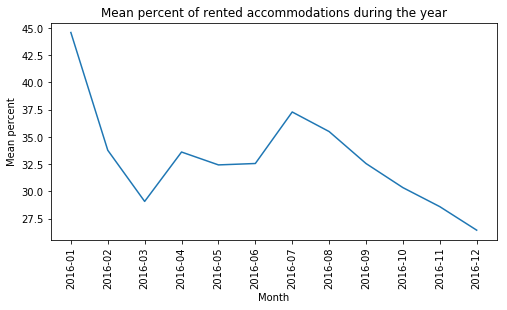

In [19]:
#lineplot of lineplot_data
plt.figure(figsize=(8, 4))

sns.lineplot(data=lineplot_data, x='date', y='rented')
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Mean percent')
plt.title('Mean percent of rented accommodations during the year');

From a line plot above it's easy to see that most accommodations are rented in January and June (but in June much less than in January) while most of the placements are free in November and December

### Question 2
<i>« Which accommodations are the most popular and are rent almost for the whole time and which accommodations aren't popular at all? »</i>

To answer this question we need to use `df_listing` dataset as well as `df_calendar`. So, first of all, we have to clear `df_listing`. Also, I set `id` as an index in `df_listing` because it makes a finding of particular placement process much easier

In [20]:
df_listing.set_index('id', inplace=True)
df_listing.head()

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,Belltown,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


Before starting the cleaning process we need to decide which columns from `df_listing` we actually need. That's why I decided to print titles of all columns of this dataframe and after that to group interesting for future analysis columns in two categories: categorical and numerical

In [21]:
df_listing.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square

In [22]:
categorical = ['neighbourhood_cleansed', 'property_type', 'room_type',
               'bed_type', 'cancellation_policy', 'instant_bookable',
               'require_guest_profile_picture', 'require_guest_phone_verification']
numerical = ['accommodates', 'bathrooms', 'beds', 'square_feet', 'price',
             'cleaning_fee', 'security_deposit', 'guests_included']

In [23]:
#now df_listing contains only the columns that important for our analysis
df_listing = df_listing[categorical + numerical]
df_listing.head()

,neighbourhood_cleansed,property_type,room_type,bed_type,cancellation_policy,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,accommodates,bathrooms,beds,square_feet,price,cleaning_fee,security_deposit,guests_included
id,,,,,,,,,,,,,,,,
241032,West Queen Anne,Apartment,Entire home/apt,Real Bed,moderate,f,f,f,4,1.0,1.0,NaN,$85.00,NaN,NaN,2
953595,West Queen Anne,Apartment,Entire home/apt,Real Bed,strict,f,t,t,4,1.0,1.0,NaN,$150.00,$40.00,$100.00,1
3308979,West Queen Anne,House,Entire home/apt,Real Bed,strict,f,f,f,11,4.5,7.0,NaN,$975.00,$300.00,"$1,000.00",10
7421966,West Queen Anne,Apartment,Entire home/apt,Real Bed,flexible,f,f,f,3,1.0,2.0,NaN,$100.00,NaN,NaN,1
278830,West Queen Anne,House,Entire home/apt,Real Bed,strict,f,f,f,6,2.0,3.0,NaN,$450.00,$125.00,$700.00,6


In [24]:
#checking info for future cleaning
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 241032 to 10208623
Data columns (total 16 columns):
neighbourhood_cleansed              3818 non-null object
property_type                       3817 non-null object
room_type                           3818 non-null object
bed_type                            3818 non-null object
cancellation_policy                 3818 non-null object
instant_bookable                    3818 non-null object
require_guest_profile_picture       3818 non-null object
require_guest_phone_verification    3818 non-null object
accommodates                        3818 non-null int64
bathrooms                           3802 non-null float64
beds                                3817 non-null float64
square_feet                         97 non-null float64
price                               3818 non-null object
cleaning_fee                        2788 non-null object
security_deposit                    1866 non-null object
guests_included              

From two cells which are above I found few problems in `df_listing`, data that must be cleaned:
1. just like in `df_calendar` format of data in `security_deposit`, `cleaning_feez` and `price` columns is unacceptable for data analysis
2. in this dataset we've got some nulls, we'll replace them to 0 a bit later. I decided to replace these nulls to 0 because in this case, nulls won't have a strong effect on final visualizations. Also, you maybe noticed that almost all `square_feet` column's values are nulls and maybe you think that it's better to remove this column however I decided to leave this column alone for now because theoretically, it may contain some useful for our analysis information
3. change type of all categorical column to 'category'

In [25]:
#change prices format using function
df_listing.security_deposit = format_price(df_listing, df_listing.security_deposit)
df_listing.cleaning_fee = format_price(df_listing, df_listing.cleaning_fee)
df_listing.price = format_price(df_listing, df_listing.price)

Now, it's lime to group this dataset in two subsets, one for very popular placements and other for less popular

In [26]:
#series with data about popularity of each accommodation
mean_available = df_calendar.groupby('listing_id').available.mean()

#let's most popular accommodations will be available not more than 5% of all time
#while less popular - not less than 95% of all time
#varibels below contain indexes of most_pop_index and less_pop_index respectively
most_pop_index = mean_available[mean_available <= 0.05].index
less_pop_index = mean_available[mean_available >= 0.95].index

#varibels below contain rows of most popular less popular accommodations respectively
most_pop = df_listing.loc[most_pop_index]
less_pop = df_listing.loc[less_pop_index]

#let's add to these dataframes pop columns, because we will combine these dataframes soon
most_pop['pop'] = 't'
less_pop['pop'] = 'f'

#in our visualization we need to have the same quantity of rows in each dataframe
#otherwise our inferences can be not objective
print('Shape of most_pop: {}'.format(most_pop.shape))
print('Shape of less_pop: {}'.format(less_pop.shape))

Shape of most_pop: (216, 17)
Shape of less_pop: (1376, 17)


Now, it makes sense to combine all rows of most_pop with random 216 rows from less_pop

In [27]:
appartment_popularity = most_pop.append(less_pop.sample(216, random_state=42))

#replace all nans to 0
appartment_popularity.fillna(0, inplace=True)

#changing type of all categorical column to 'category'
appartment_popularity[categorical] = appartment_popularity[categorical].astype('category')

In [28]:
#checking changes
appartment_popularity.head()

,neighbourhood_cleansed,property_type,room_type,bed_type,cancellation_policy,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,accommodates,bathrooms,beds,square_feet,price,cleaning_fee,security_deposit,guests_included,pop
listing_id,,,,,,,,,,,,,,,,,
107046,Ravenna,House,Entire home/apt,Real Bed,strict,f,f,f,8,2.0,6.0,0.0,280,150,550,6,t
261912,Green Lake,House,Entire home/apt,Real Bed,strict,f,f,t,4,1.0,2.0,0.0,175,0,400,2,t
284813,Belltown,Apartment,Entire home/apt,Real Bed,strict,f,f,t,2,1.0,1.0,0.0,159,95,300,2,t
445199,North Delridge,House,Entire home/apt,Real Bed,moderate,t,t,t,5,1.0,3.0,0.0,129,89,300,2,t
451012,Broadview,House,Entire home/apt,Real Bed,moderate,f,f,f,6,2.0,4.0,0.0,195,200,0,6,t


In [29]:
#checking changes
appartment_popularity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 432 entries, 107046 to 1594412
Data columns (total 17 columns):
neighbourhood_cleansed              432 non-null category
property_type                       432 non-null category
room_type                           432 non-null category
bed_type                            432 non-null category
cancellation_policy                 432 non-null category
instant_bookable                    432 non-null category
require_guest_profile_picture       432 non-null category
require_guest_phone_verification    432 non-null category
accommodates                        432 non-null int64
bathrooms                           432 non-null float64
beds                                432 non-null float64
square_feet                         432 non-null float64
price                               432 non-null int64
cleaning_fee                        432 non-null int64
security_deposit                    432 non-null int64
guests_included                

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 576x720 with 0 Axes>

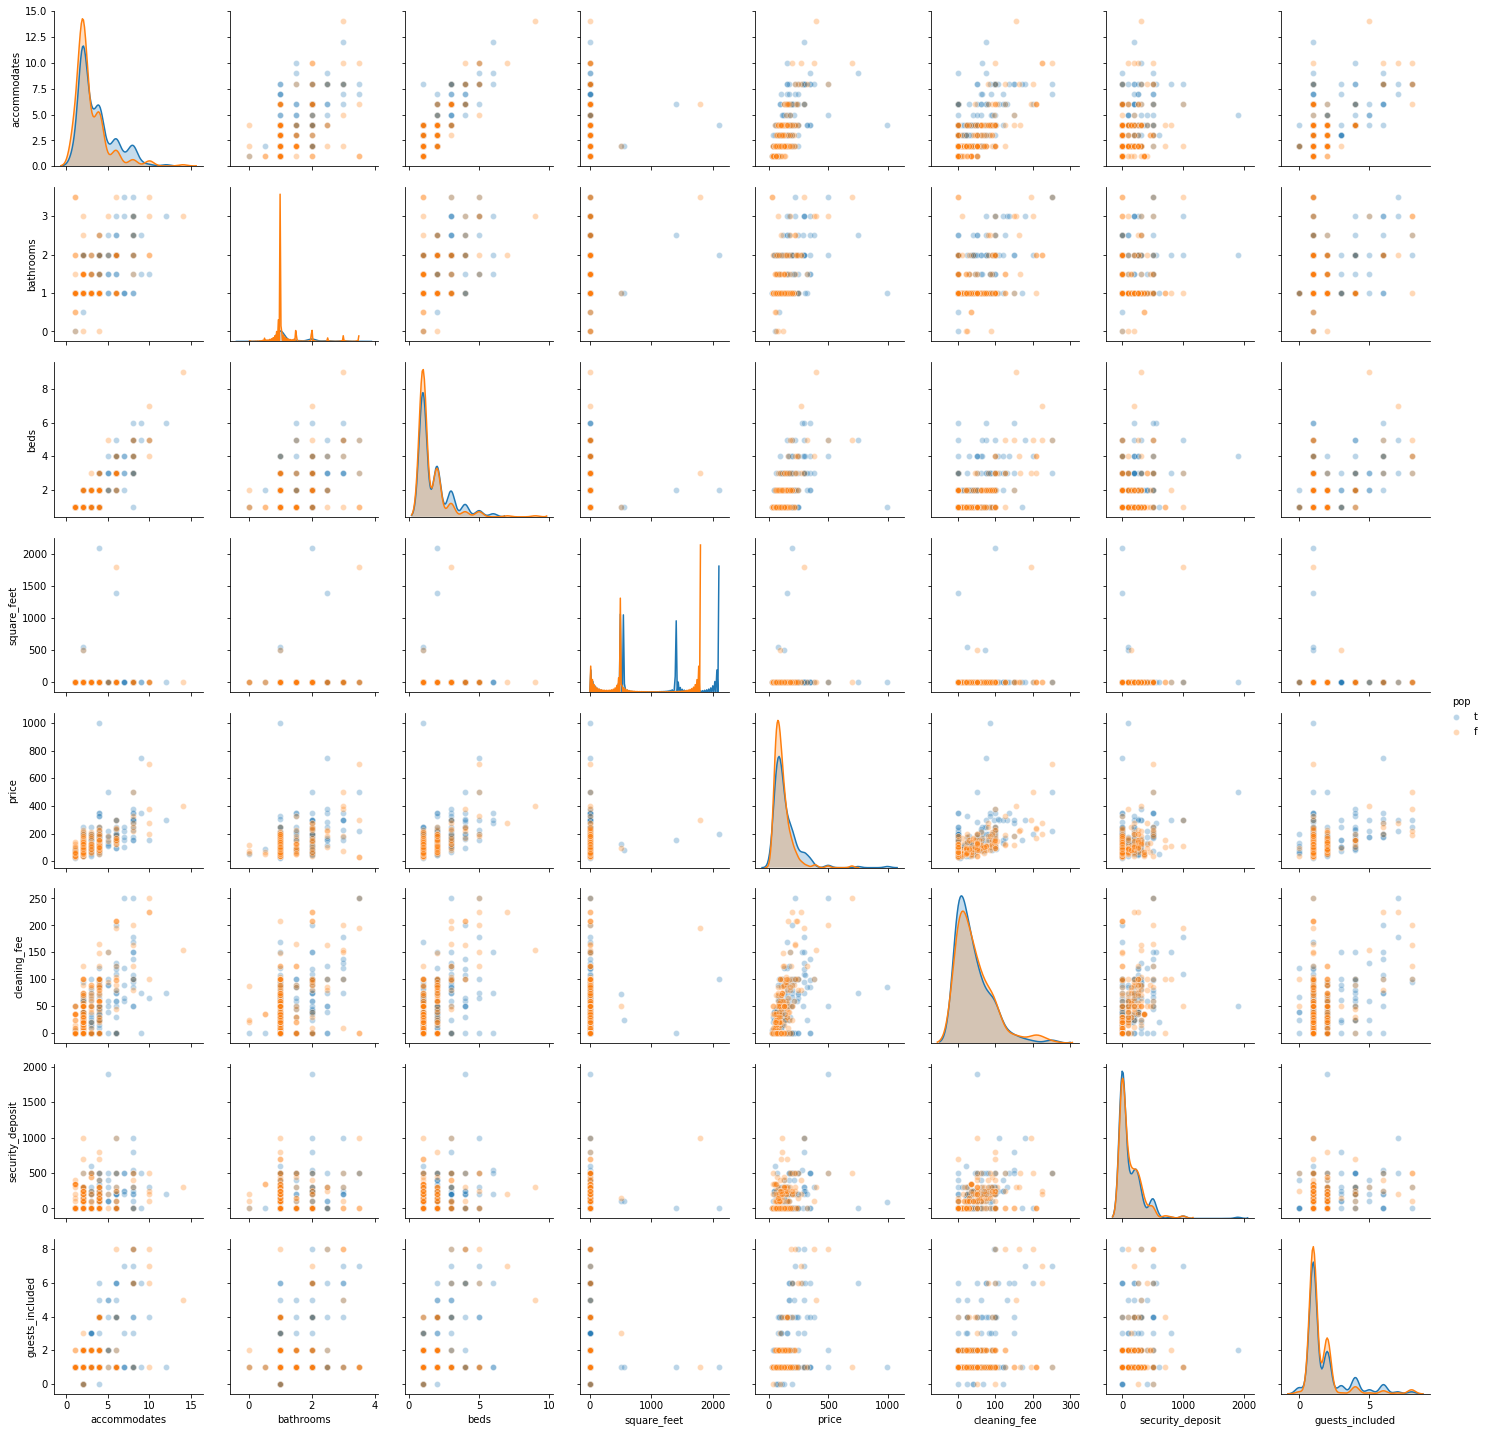

In [30]:
#pairplot visualization of numerical columns from appartment_popularity
plt.figure(figsize=(8, 10))
sns.pairplot(appartment_popularity, hue='pop', plot_kws={'alpha' : 0.3});

We've got some graphs above. In these graphs, we're able to find some data patterns, but I don't think that we actually able to find here something obvious, maybe it makes sense to investigate categorical data more

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead


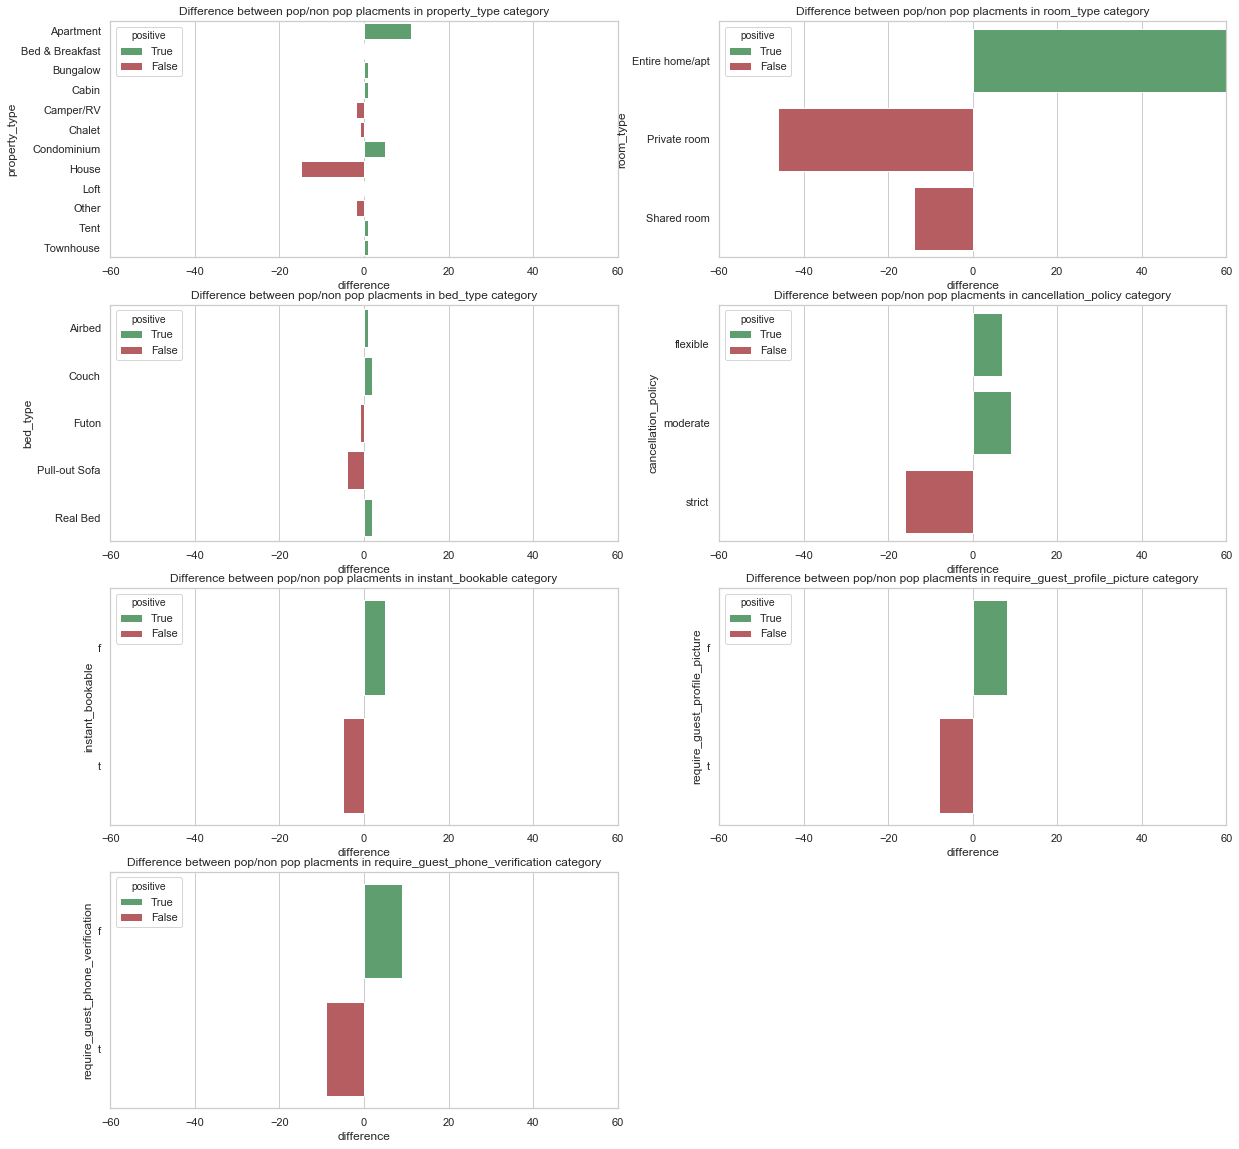

In [31]:
sns.set(style='whitegrid')
plt.figure(figsize=(20,20))
for i in range(len(categorical)):
    if i == 0:
        continue
    else:
        plt.subplot(4, 2, i)
        difference(appartment_popularity, categorical[i]);

Two cells above have a ton of useful information to analyze. First of all, of visualizations have same xlim parameters (-60,60), that's why we can easily find what difference between popular and unpopular accommodations. 

### Characteristic of popular accommodation for rent:

<ul>
    <li><i>property_type:</i> Apartment, Condominium</li>
    <li><i>room_type:</i> Entire home/apt</li>
    <li><i>bed_type:</i> Real Bed, Couch</li>
    <li><i>cancellation_policy:</i> flexible, moderate</li>
    <li><i>instant_bookable:</i> False</li>
    <li><i>require_guest_profile_picture:</i> False</li>
    <li><i>require_guest_phone_verification:</i> False</li>
</ul>

### Characteristic of unpopular accommodation for rent:
<ul>
    <li><i>property_type:</i> Camper/RV, House, Other</li>
        <li><i>room_type:</i> Private room, Shared room</li>
        <li><i>bed_type:</i> Pull-out Sofa</li>
        <li><i>cancellation_policy:</i> strict</li>
        <li><i>instant_bookable:</i> True</li>
        <li><i>require_guest_profile_picture:</i> True</li>
        <li><i>require_guest_phone_verification:</i> True</li>
</ul>


### Question 3
<i>« In which areas are the most popular accommodations for rent, and in which are the least popular? »</i>

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead


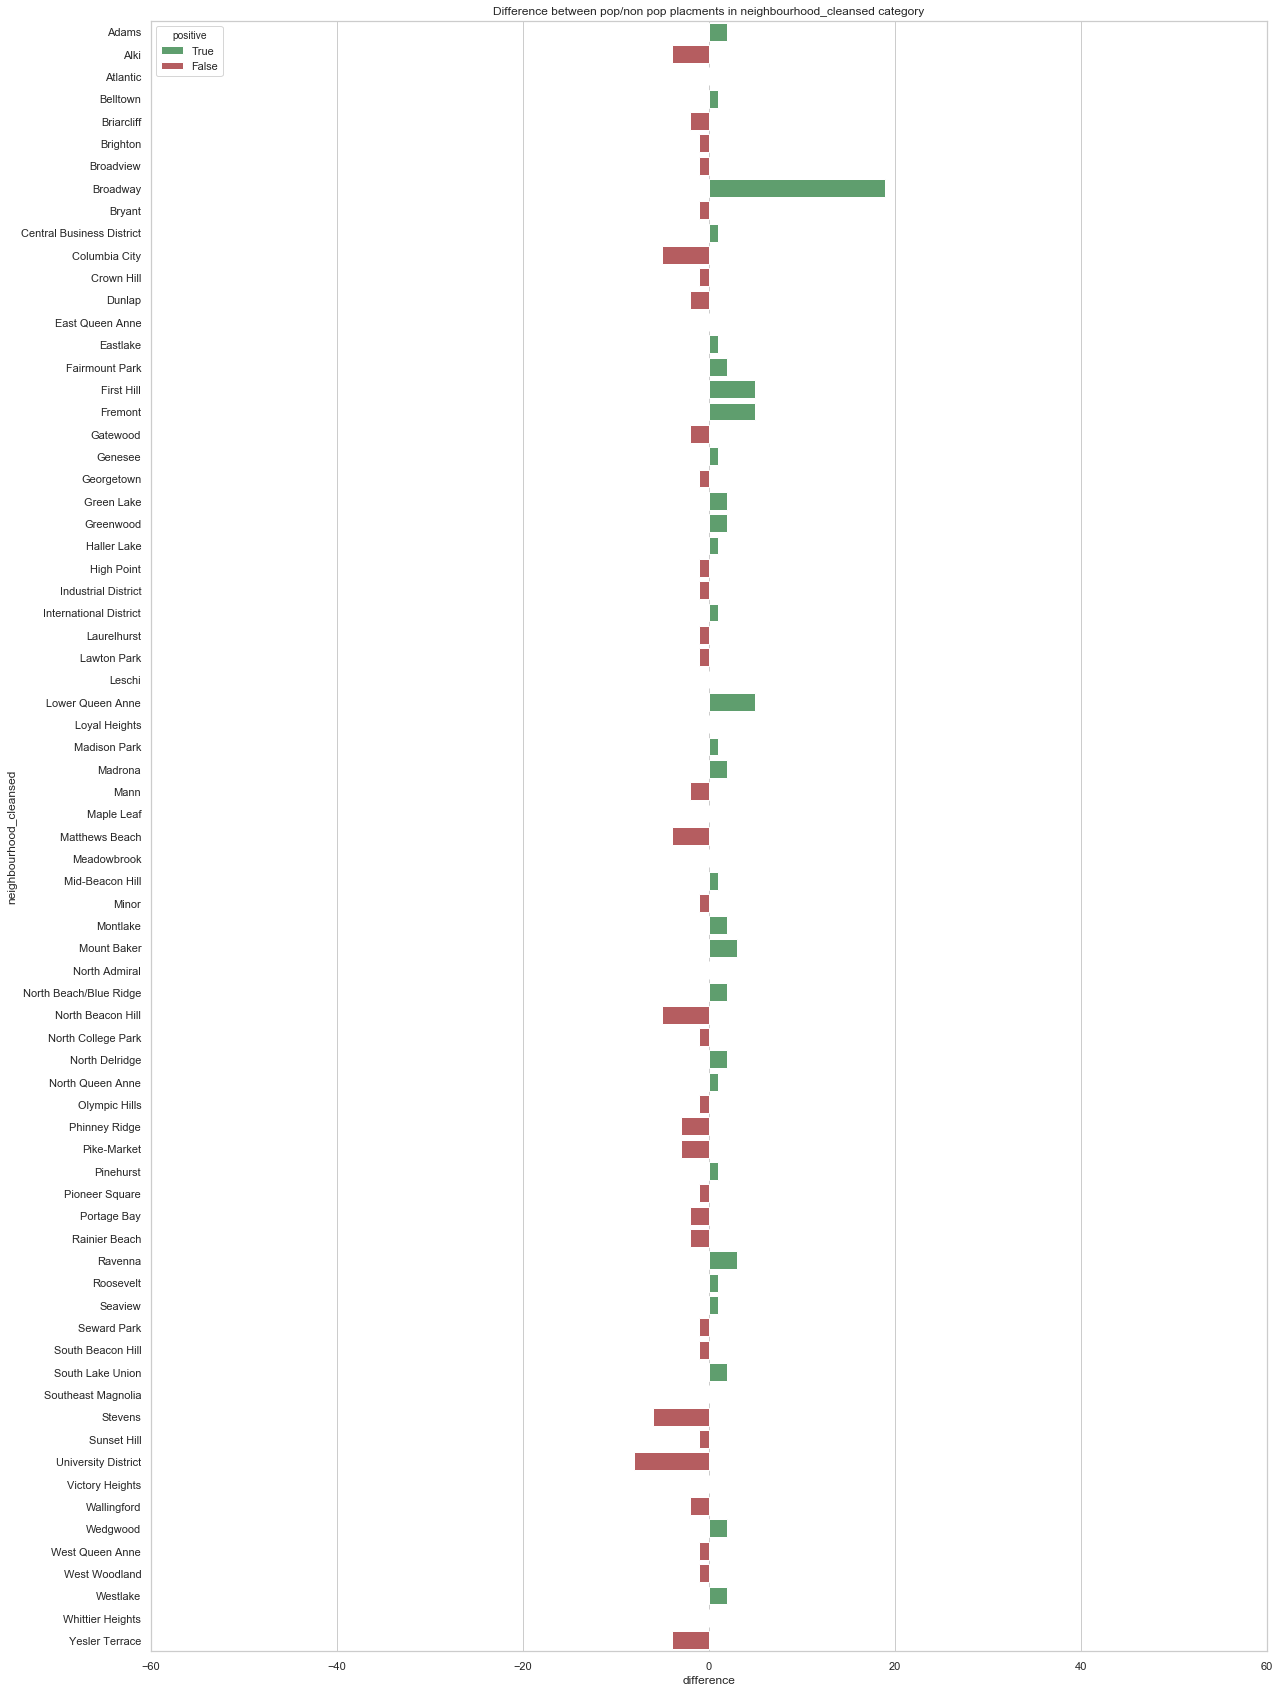

In [32]:
plt.figure(figsize=(20,30))
diff = difference(appartment_popularity, 'neighbourhood_cleansed', return_df_diff=True);

### Neighborhoods of popular accommodation:
<ul><li>Adams</li>
    <li>Belltown</li>
    <li>Broadway</li>
    <li>Central Business District</li>
    <li>Eastlake</li>
    <li>Fairmount Park</li>
    <li>First</li>
    <li>Hill</li>
    <li>Fremont</li>
    <li>Genesee</li>
    <li>Green Lake</li>
    <li>Greenwood</li>
    <li>Haller Lake</li>
    <li>International District</li>
    <li>Lower Queen Anne</li>
    <li>Madison Park</li>
    <li>Madrona</li>
    <li>Mid-Beacon Hill</li>
    <li>Montlake</li>
    <li>Mount Baker</li>
    <li>North Beach/Blue Ridge</li>
    <li>North Delridge</li>
    <li>North Queen Anne</li>
    <li>Pinehurst</li>
    <li>Ravenna</li>
    <li>Roosevelt</li>
    <li>Seaview</li>
    <li>South Lake Union</li>
    <li>Wedgwood</li>
    <li>Westlake</li>
</ul>

### Neighborhoods of unpopular accommodation:
<ul><li>Alki</li>
    <li>Atlantic</li>
    <li>Briarcliff</li>
    <li>Brighton</li>
    <li>Broadview</li>
    <li>Bryant</li>
    <li>Columbia City</li>
    <li>Crown Hill</li>
    <li>Dunlap</li>
    <li>East Queen Anne</li>
    <li>Gatewood</li>
    <li>Georgetown</li>
    <li>High Point</li>
    <li>Industrial District</li>
    <li>Laurelhurst</li>
    <li>Lawton Park</li>
    <li>Leschi</li>
    <li>Loyal Heights</li>
    <li>Mann</li>
    <li>Maple Leaf</li>
    <li>Matthews Beach</li>
    <li>Meadowbrook</li>
    <li>Minor</li>
    <li>North Admiral</li>
    <li>North Beacon Hill</li>
    <li>North College Park</li>
    <li>Olympic Hills</li>
    <li>Phinney Ridge</li>
    <li>Pike-Market</li>
    <li>Pioneer Square</li>
    <li>Portage Bay</li>
    <li>Rainier Beach</li>
    <li>Seward Park</li>
    <li>South Beacon Hill</li>
    <li>Southeast Magnolia</li>
    <li>Stevens</li>
    <li>Sunset Hill</li>
    <li>University District</li>
    <li>Victory Heights</li>
    <li>Wallingford</li>
    <li>West Queen Anne</li>
    <li>West Woodland</li>
    <li>Whittier Heights</li>
    <li>Yesler Terrace</li>
</ul>